In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K

In [2]:
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [5]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [7]:
trainX, testX = scale_data(trainX, testX)

In [8]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [10]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [11]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-11-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [12]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-12-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [13]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [14]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [15]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [16]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [20]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [22]:
class_breakdown(y_train)

Class=1, total=877, percentage=30.815
Class=2, total=972, percentage=34.153
Class=3, total=997, percentage=35.032


<h1>Traning</h1>

In [25]:
def conv_block(in_x, nb_filter, kernel_size):

    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [27]:
def convolutional_block(in_x, nb_filters, stride):

    F1, F2, F3 = nb_filters

    x = in_x

    x = Conv1D(F1, 3, strides=stride,  padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F2, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F3, 1, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    #----------------------------------------------

    x1 = Conv1D(F3, 1, strides=stride, padding='same', kernel_initializer="he_normal")(in_x)
    x1 = BatchNormalization()(x1)

    x = add([x, x1])
    x = Activation('relu')(x)

    return x

In [28]:
# SE block은 채널 마다 가중치를 주어 합성곱을 수행
# 채널 간의 의존성을 고려하여 효과적인 특성 강조를 수행하는 방법 동입
# squeeze : Global average pooling을 사용하여 채널별로 평균값을 계산하여 각 채널의 중요도를 파악한다.
# excitation : Fully connected layer , 활성화함수를 통해서 각 채널의 가중치 조정, 채널 같의 관계 모델링
def se_block(in_x, nb_filter):
        # GAP층 사용하여 (특징 맵에서 각 채널의 평균으로 축소)
        squeeze = GlobalAveragePooling1D()(in_x)
        # flatten 층 없이 cnn의 특성 맵을 직접 dense층에 입력 -> 공간 정보를 유지한 채로 전달한다.
        excitation = Dense(units=nb_filter // 2)(squeeze)
        # 필터의 개수는 입력 -> 출력에서 얼마다 다운샘플링 하는지 비율을 뜻한다.
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=nb_filter)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,nb_filter))(excitation)
        # 처음 필터의 개수 ( 채널 수)로 reshape하여 각 채널의 중요도(가중치)를 채널에 곱하는 연산을 수행
        scale = multiply([in_x,excitation])
        out = add([in_x, scale])

        return out

In [29]:
def SENET():

    inputs = Input(shape=(n_timesteps,n_features))
    # (none, 128, 9)
    x = Conv1D(16, 32, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 16)
    x = MaxPooling1D(4)(x)

    x = Conv1D(32, 16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 32)
    x = MaxPooling1D(4)(x)

    x = Flatten()(x)
    x = Dense(128,  activation='relu')(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = keras.Model(inputs, x)

    return model

In [30]:
model = SENET()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 128, 16)              4624      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 16)              0         ['batch_normalization[0][0

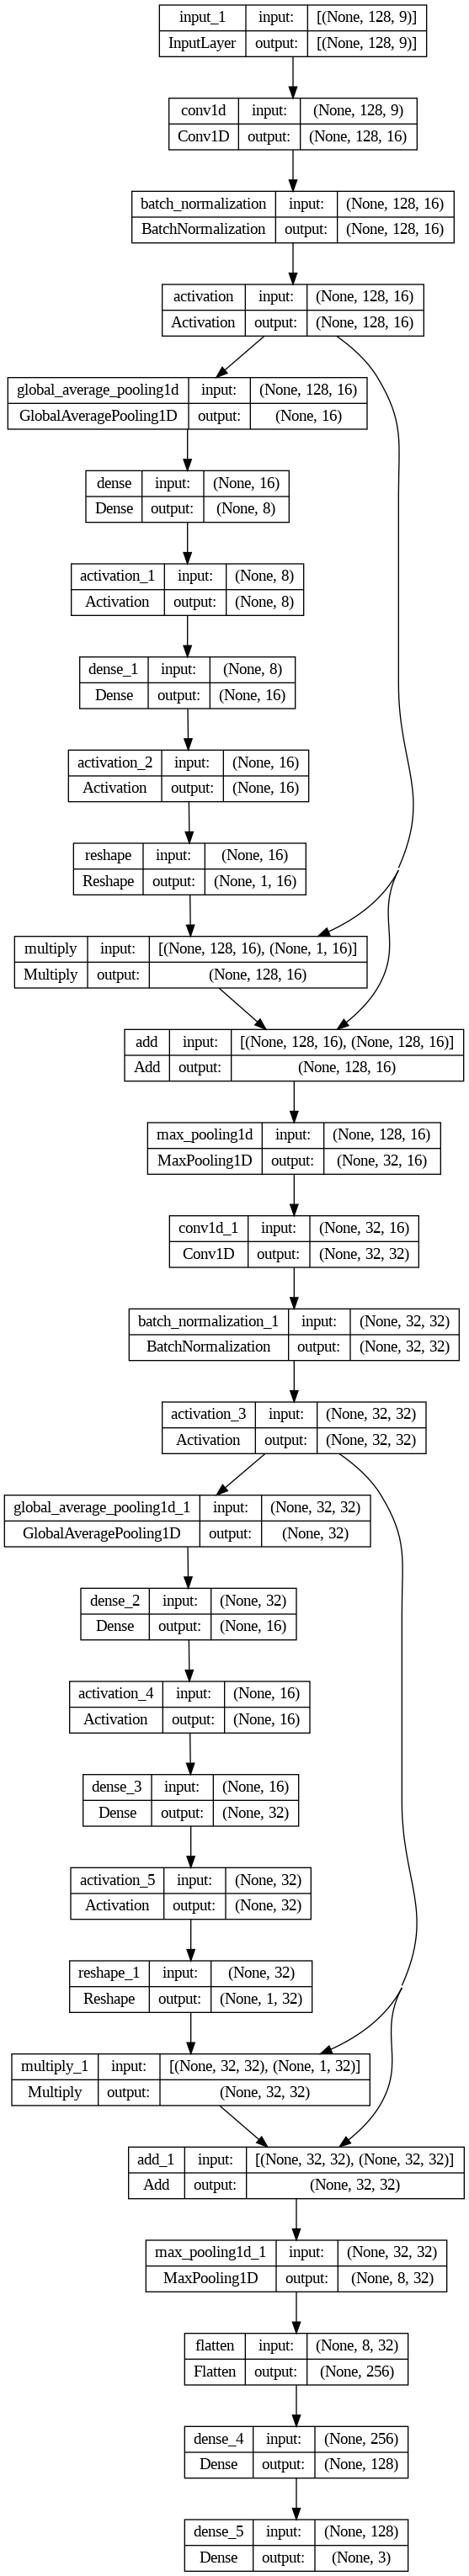

In [31]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [32]:
# validation_split = 0.1
batch_size = 32

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/100
128/128 [==============================] - 8s 20ms/step - loss: 0.2657 - accuracy: 0.8925 - val_loss: 0.2070 - val_accuracy: 0.9050
Epoch 2/100
128/128 [==============================] - 2s 17ms/step - loss: 0.2290 - accuracy: 0.9007 - val_loss: 0.2371 - val_accuracy: 0.9083
Epoch 3/100
128/128 [==============================] - 2s 18ms/step - loss: 0.2340 - accuracy: 0.9024 - val_loss: 0.2106 - val_accuracy: 0.9156
Epoch 4/100
128/128 [==============================] - 3s 25ms/step - loss: 0.2260 - accuracy: 0.9031 - val_loss: 0.1959 - val_accuracy: 0.9140
Epoch 5/100
128/128 [==============================] - 3s 24ms/step - loss: 0.2053 - accuracy: 0.9127 - val_loss: 0.1806 - val_accuracy: 0.9271
Epoch 6/100
128/128 [==============================] - 3s 27ms/step - loss: 0.2079 - accuracy: 0.9090 - val_loss: 0.1768 - val_accuracy: 0.9287
Epoch 7/100
128/128 [==============================] - 4s 31ms/step - loss: 0.2010 - accuracy: 0.9169 - val_loss: 0.1945 - val_accuracy:

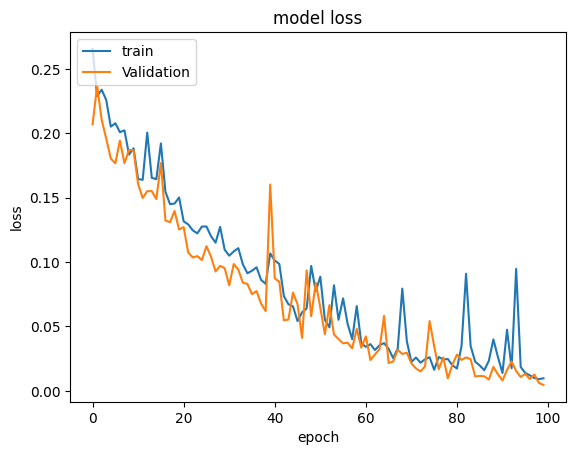

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')


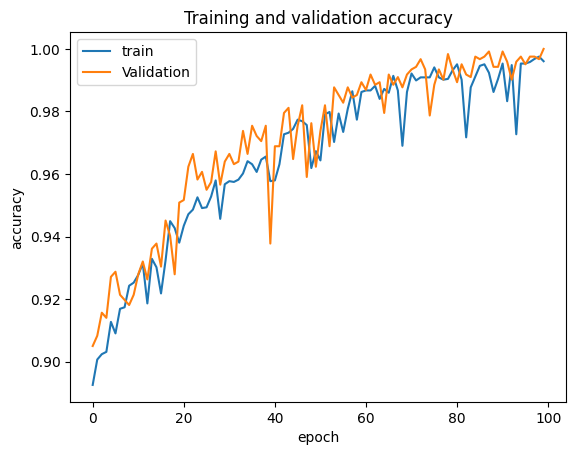

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 6ms/step
[[428  63   0]
 [ 19 513   0]
 [  0   0 537]]
0.9474358974358974
0.9472467422478198
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       491
           1       0.89      0.96      0.93       532
           2       1.00      1.00      1.00       537

    accuracy                           0.95      1560
   macro avg       0.95      0.95      0.95      1560
weighted avg       0.95      0.95      0.95      1560



<Axes: >

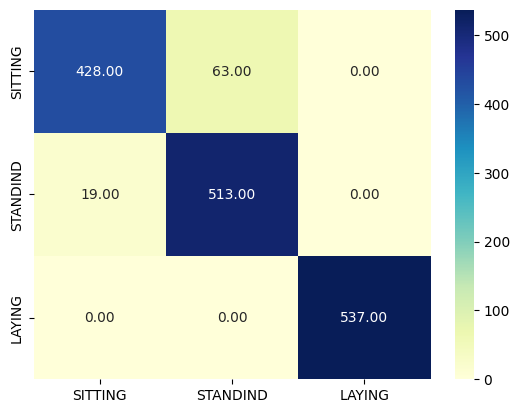

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [36]:
def en_loss(y_true, y_pred):

    epsilon = 1.e-7
    gamma = float(0.3)

    y_true = tf.cast(y_true, tf.float32)
    # 텐서의 데이터 타입 변경
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    # 텐서의 값을 지정된 범위로 제한. : y_pred의 값을 epsilon과 1. - epsilon 사이
    pos_pred = tf.pow(-tf.math.log(y_pred),gamma)
    nag_pred = tf.pow(-tf.math.log(1-y_pred),gamma)
    y_t = tf.multiply(y_true, pos_pred) + tf.multiply(1-y_true, nag_pred)
    en_loss = tf.reduce_mean(y_t)
    return en_loss

In [37]:
model = SENET()
model.summary()
model.compile(optimizer = 'adam', loss=en_loss, metrics = ["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 128, 16)              4624      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 128, 16)              64        ['conv1d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_6 (Activation)   (None, 128, 16)              0         ['batch_normalization_2[

In [38]:
# validation_split = 0.1
batch_size = 32

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
128/128 [==============================] - 6s 19ms/step - loss: 0.1822 - accuracy: 0.8798 - val_loss: 0.1417 - val_accuracy: 0.8993
Epoch 2/100
128/128 [==============================] - 2s 18ms/step - loss: 0.1498 - accuracy: 0.8982 - val_loss: 0.1251 - val_accuracy: 0.9255
Epoch 3/100
128/128 [==============================] - 2s 17ms/step - loss: 0.1470 - accuracy: 0.9009 - val_loss: 0.1252 - val_accuracy: 0.9238
Epoch 4/100
128/128 [==============================] - 2s 18ms/step - loss: 0.1393 - accuracy: 0.9088 - val_loss: 0.1286 - val_accuracy: 0.9066
Epoch 5/100
128/128 [==============================] - 3s 22ms/step - loss: 0.1426 - accuracy: 0.9014 - val_loss: 0.1373 - val_accuracy: 0.9009
Epoch 6/100
128/128 [==============================] - 3s 24ms/step - loss: 0.1351 - accuracy: 0.9100 - val_loss: 0.1182 - val_accuracy: 0.9214
Epoch 7/100
128/128 [==============================] - 2s 18ms/step - loss: 0.1260 - accuracy: 0.9176 - val_loss: 0.1253 - val_accuracy:

49/49 [==============================] - 0s 6ms/step
[[415  71   5]
 [ 16 516   0]
 [  0   0 537]]
0.941025641025641
0.9404847192936066
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       491
           1       0.88      0.97      0.92       532
           2       0.99      1.00      1.00       537

    accuracy                           0.94      1560
   macro avg       0.94      0.94      0.94      1560
weighted avg       0.94      0.94      0.94      1560



<Axes: >

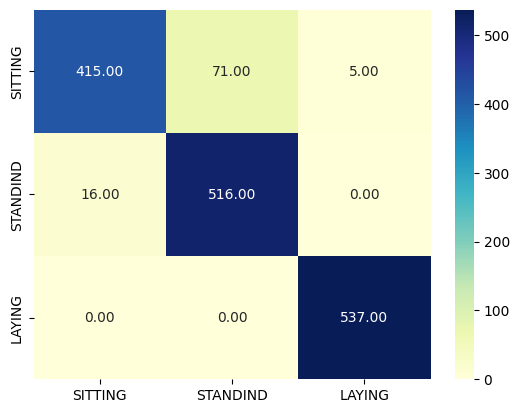

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')